<a href="https://colab.research.google.com/github/ZulfaliaPutri/Capstone_WebsiteSentimenTwitter/blob/main/Binary_Label_with_Deep_Learning_Method.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import Library**

In [56]:
from google.colab import drive
import os
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
import nltk
nltk.download('stopwords')
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords

from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Load Data**

In [57]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [58]:
df = pd.read_csv('/content/gdrive/My Drive/Capstone/dataset/data_clean.csv')
df.head()

,Unnamed: 0,Tweet,HS,Abusive
0,0,cowok usaha lacak perhati gue lantas remeh per...,1,1
1,1,rt guna guna telat tau edan sarap gue gaul cig...,0,1
2,2,41 kadang pikir percaya tuhan jatuh kali kali ...,0,0
3,3,guna guna ku tau mata sipit,0,0
4,4,guna guna kaum cebong kafir dongok dungu haha,1,1


**Menggabungkan label Hate Speech dan Abusive**

In [59]:
df['HS_Abusive'] = np.where((df['HS'] == 1) | (df['Abusive'] == 1), 1, 0)
df

,Unnamed: 0,Tweet,HS,Abusive,HS_Abusive
0,0,cowok usaha lacak perhati gue lantas remeh per...,1,1,1
1,1,rt guna guna telat tau edan sarap gue gaul cig...,0,1,1
2,2,41 kadang pikir percaya tuhan jatuh kali kali ...,0,0,0
3,3,guna guna ku tau mata sipit,0,0,0
4,4,guna guna kaum cebong kafir dongok dungu haha,1,1,1
...,...,...,...,...,...
13164,13164,guna bicara ndasmu congor sekata anjing,1,1,1
13165,13165,guna kasur enak kunyuk,0,1,1
13166,13166,guna hati hati bisu bosan duh x98,0,0,0
13167,13167,guna guna guna guna bom real mudah deteksi bom...,0,0,0


**Menghapus kolom yang tidak diperlukan**

In [60]:
df = df.drop(columns=["Unnamed: 0","HS","Abusive"])
df

,Tweet,HS_Abusive
0,cowok usaha lacak perhati gue lantas remeh per...,1
1,rt guna guna telat tau edan sarap gue gaul cig...,1
2,41 kadang pikir percaya tuhan jatuh kali kali ...,0
3,guna guna ku tau mata sipit,0
4,guna guna kaum cebong kafir dongok dungu haha,1
...,...,...
13164,guna bicara ndasmu congor sekata anjing,1
13165,guna kasur enak kunyuk,1
13166,guna hati hati bisu bosan duh x98,0
13167,guna guna guna guna bom real mudah deteksi bom...,0


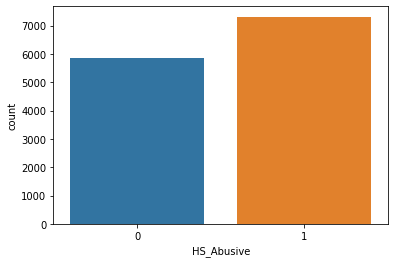

In [61]:
sns.countplot(x='HS_Abusive', data=df)

In [62]:
df.isnull().sum()

Tweet         6
HS_Abusive    0
dtype: int64

**Menghapus baris yang memiliki nilai null**

In [63]:
df = df.dropna()
df

,Tweet,HS_Abusive
0,cowok usaha lacak perhati gue lantas remeh per...,1
1,rt guna guna telat tau edan sarap gue gaul cig...,1
2,41 kadang pikir percaya tuhan jatuh kali kali ...,0
3,guna guna ku tau mata sipit,0
4,guna guna kaum cebong kafir dongok dungu haha,1
...,...,...
13164,guna bicara ndasmu congor sekata anjing,1
13165,guna kasur enak kunyuk,1
13166,guna hati hati bisu bosan duh x98,0
13167,guna guna guna guna bom real mudah deteksi bom...,0


In [64]:
df.isnull().sum()

Tweet         0
HS_Abusive    0
dtype: int64

**Menambahkan kolom length yang menampung panjang dari setiap tweet**

In [65]:
df['length'] = df['Tweet'].apply(len)
df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Tweet,HS_Abusive,length
0,cowok usaha lacak perhati gue lantas remeh per...,1,84
1,rt guna guna telat tau edan sarap gue gaul cig...,1,64
2,41 kadang pikir percaya tuhan jatuh kali kali ...,0,119
3,guna guna ku tau mata sipit,0,27
4,guna guna kaum cebong kafir dongok dungu haha,1,45
...,...,...,...
13164,guna bicara ndasmu congor sekata anjing,1,39
13165,guna kasur enak kunyuk,1,22
13166,guna hati hati bisu bosan duh x98,0,33
13167,guna guna guna guna bom real mudah deteksi bom...,0,80


**Mendefinisikan nilai X dan y**

In [66]:
X = df['Tweet'].values
y = df['HS_Abusive'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

In [67]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Embedding Layer
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

maxlen = max(df['length'])

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [68]:
from numpy import asarray
#Fasttext Embedding
#file source : https://github.com/meisaputri21/Indonesian-Twitter-Emotion-Dataset
embeddings_dictionary = dict()
fasttext = open('/content/gdrive/My Drive/Capstone/cc.id.300.vec', encoding='utf-8')

for line in fasttext:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
fasttext.close()

In [69]:
from numpy import zeros
import numpy as np
# Membuat embedding matrix
null_word=[]
embedding_matrix = zeros((vocab_size, 300))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
      embedding_matrix[index] = embedding_vector
    else:
      #word.append(null_word)
      null_word += [word]
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

number of null word embeddings: 619


**Modelling with Bidirectional GRU-CNN-LSTM**

In [74]:
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Conv1D, GRU, BatchNormalization
from keras.layers import Bidirectional, GlobalMaxPool1D, MaxPooling1D, Add, Flatten
from keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate, SpatialDropout1D
from keras.models import Model, load_model
from keras import initializers, regularizers, constraints, optimizers, layers, callbacks
from keras import backend as K
from tensorflow.keras.layers import Layer, InputSpec

import logging
from sklearn.metrics import roc_auc_score
from keras.callbacks import Callback

from tensorflow.keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler

#Buat function model
embed_size = 300
max_features = vocab_size

def build_model(lr = 0.0, lr_d = 0.0, units = 0, dr = 0.0):
    inp = Input(shape = (maxlen,))
    x = Embedding(max_features, embed_size, weights = [embedding_matrix], trainable = False)(inp)
    x1 = SpatialDropout1D(dr)(x)

    x = Bidirectional(GRU(units, return_sequences = True))(x1)
    #x = Conv1D(int(units/2), kernel_size = 2, kernel_regularizer=regularizers.l2(0.001), activation='relu')(x)
    x = Conv1D(int(units/2), kernel_size = 2, padding = "valid", kernel_initializer = "he_uniform")(x)
    
    y = Bidirectional(LSTM(units, return_sequences = True))(x1)
    #y = Conv1D(int(units/2), kernel_size = 2, kernel_regularizer=regularizers.l2(0.001), activation='relu')(y)
    y = Conv1D(int(units/2), kernel_size = 2, padding = "valid", kernel_initializer = "he_uniform")(y)
    
    avg_pool1 = GlobalAveragePooling1D()(x)
    max_pool1 = GlobalMaxPooling1D()(x)
    
    avg_pool2 = GlobalAveragePooling1D()(y)
    max_pool2 = GlobalMaxPooling1D()(y)
    
    x = concatenate([avg_pool1, max_pool1, avg_pool2, max_pool2])
    x = Dense(16, activation="relu")(x)
    #x = Dropout(0.5)(x)
    x = Dense(32, activation="relu")(x)
    x = Dropout(0.2)(x)
    #x = Dense(64, activation="relu")(x)
    #x = Dropout(0.1)(x)
    x = Dense(1, activation = "sigmoid")(x)
    model = Model(inputs = inp, outputs = x)
    model.compile(loss = "binary_crossentropy", optimizer = Adam(learning_rate = lr, decay = lr_d), metrics = ["accuracy"])

    return model

In [75]:
model = build_model(lr = 1e-3, lr_d = 0, units = 112, dr = 0.2)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 348)]        0           []                               
                                                                                                  
 embedding_7 (Embedding)        (None, 348, 300)     3255000     ['input_2[0][0]']                
                                                                                                  
 spatial_dropout1d_1 (SpatialDr  (None, 348, 300)    0           ['embedding_7[0][0]']            
 opout1D)                                                                                         
                                                                                                  
 bidirectional_2 (Bidirectional  (None, 348, 224)    278208      ['spatial_dropout1d_1[0][0]

In [76]:
import tensorflow as tf

#Predict model
callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0, patience=10, verbose=2, mode='auto', restore_best_weights=True)
#history = model.fit(X_train, y_train, batch_size = 128, epochs = 50, validation_data = (X_test, y_test), verbose = 1, callbacks=[callbacks])
history = model.fit(X_train, y_train, batch_size = 128, epochs = 10, validation_data = (X_test, y_test), verbose = 1)
#pred = model.predict(test, batch_size = 1024, verbose = 1)

Epoch 1/10
83/83 [==============================] - 445s 5s/step - loss: 0.5656 - accuracy: 0.7021 - val_loss: 0.4705 - val_accuracy: 0.7771
Epoch 2/10
83/83 [==============================] - 424s 5s/step - loss: 0.4401 - accuracy: 0.8028 - val_loss: 0.4201 - val_accuracy: 0.8063
Epoch 3/10
83/83 [==============================] - 427s 5s/step - loss: 0.4050 - accuracy: 0.8196 - val_loss: 0.3920 - val_accuracy: 0.8230
Epoch 4/10
83/83 [==============================] - 434s 5s/step - loss: 0.3737 - accuracy: 0.8396 - val_loss: 0.3992 - val_accuracy: 0.8173
Epoch 5/10
83/83 [==============================] - 441s 5s/step - loss: 0.3409 - accuracy: 0.8573 - val_loss: 0.3650 - val_accuracy: 0.8374
Epoch 6/10
83/83 [==============================] - 429s 5s/step - loss: 0.3110 - accuracy: 0.8709 - val_loss: 0.3628 - val_accuracy: 0.8378
Epoch 7/10
83/83 [==============================] - 431s 5s/step - loss: 0.2903 - accuracy: 0.8816 - val_loss: 0.3558 - val_accuracy: 0.8371
Epoch 8/10
83

In [77]:
# Hasil score model 
score = model.evaluate(X_test, y_test, verbose=1)

83/83 [==============================] - 43s 514ms/step - loss: 0.3588 - accuracy: 0.8466


In [80]:
print("Test Loss:", score[0])
print("Test Accuracy:", score[1])

Test Loss: 0.35884949564933777
Test Accuracy: 0.8465628623962402


In [81]:
from sklearn.metrics import classification_report
num_classes = 2
predicted_classes = model.predict(X_test)
target_names = ["Class {}".format(i) for i in range(num_classes)]
print(classification_report(y_test, predicted_classes.round(), target_names=target_names))

              precision    recall  f1-score   support

     Class 0       0.85      0.81      0.83      1218
     Class 1       0.84      0.88      0.86      1415

    accuracy                           0.85      2633
   macro avg       0.85      0.84      0.85      2633
weighted avg       0.85      0.85      0.85      2633



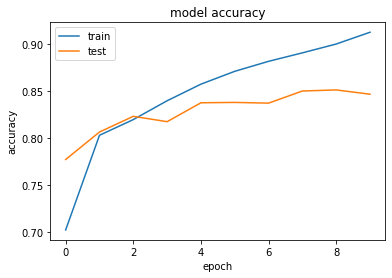

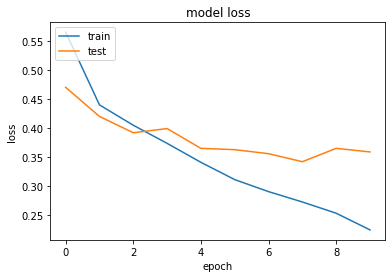

In [82]:
import matplotlib.pyplot as plt

# Plotting model accuracy dan loss
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()